In [1]:
! wget https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar

--2021-08-06 07:52:14--  https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t0ichx42vg218hc/PH2Dataset.rar [following]
--2021-08-06 07:52:14--  https://www.dropbox.com/s/raw/t0ichx42vg218hc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucee46cf08a940d0c5ac30c89d35.dl.dropboxusercontent.com/cd/0/inline/BTtqjBZM3zyCYadNTpbwlwJRsTmX2AE0pXcPQvPWMLiYcoU0-SKWSEYmmsQ40KBvhHz3IAm4QGveR6lsdzxe-v_4T9d_qzIrdaIVHZRL3Kdqz70IwA8rClc2aUPiu1Roff9liMI4kiZOFCQkQWwdZYxm/file# [following]
--2021-08-06 07:52:15--  https://ucee46cf08a940d0c5ac30c89d35.dl.dropboxusercontent.com/cd/0/inline/BTtqjBZM3zyCYadNTpbwlwJRsTmX2AE0pXcPQvPWMLiYcoU0-SKWSEYmmsQ40KBvhHz3IAm4QGveR6lsdzx

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))


from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [3]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

def bce_loss(y_real, y_pred):
    return (y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))).sum()


def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    X_val, Y_val = X_val.to(device), Y_val.to(device) 
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            
            # data to device
            model.to(device)
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model.forward(X_batch).to(device)
            print('Make Forward!')
            
            loss =  loss_fn(Y_batch,Y_pred )
            print('Calc Loss!')

            loss.backward()
            print('Make Backward!')

            opt.step()
            print('Step!')


            # calculate loss to show the user

            avg_loss += loss / len(data_tr)

        loss_train_plot.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results

        model.eval()  # testing mode
        
        with torch.no_grad():
          loss_val_plot.append(loss_fn(Y_val, model(X_val) ).sum())
          Y_hat = model(X_val).cpu().detach().numpy()
          print('Eval succesfull!')

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().detach().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='binary')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

import numpy as np
import scipy.misc as misc

def GetIOU(Pred,GT,NumClasses,ClassNames=[], DisplyResults=False, thresh = 0.5): #Given A ground true and predicted labels return the intersection over union for each class
    # and the union for each class
    ClassIOU=np.zeros(NumClasses)#Vector that Contain IOU per class
    ClassWeight=np.zeros(NumClasses)#Vector that Contain Number of pixel per class Predicted U Ground true (Union for this class)
    for i in range(NumClasses): # Go over all classes
        Intersection=np.float32(np.sum((Pred==GT)*(GT==i)))# Calculate intersection
        Union=np.sum(GT==i)+np.sum(Pred==i)-Intersection # Calculate Union
        if Union>0:
            ClassIOU[i]=Intersection/Union# Calculate intesection over union
            ClassWeight[i]=Union

    #------------Display results-------------------------------------------------------------------------------------
    # if DisplyResults:
    #    for i in range(len(ClassNames)):
    #         print(ClassNames[i]+") "+str(ClassIOU[i]))
    #    print("Mean Classes IOU) "+str(np.mean(ClassIOU)))
    #    print("Image Predicition Accuracy)" + str(np.float32(np.sum(Pred == GT)) / GT.size))
    #-------------------------------------------------------------------------------------------------

    return ClassIOU #, ClassWeight

def score_model(model, metric, data, thresh=0.5, NumClasses = 1):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data_val:
        print('count batches iter')
        Y_pred = unet_model(X_batch.to(device))
        outputs = Y_pred.squeeze(1).byte().cpu().detach().numpy() # BATCH x 1 x H x W => BATCH x H x W
        labels = Y_label.squeeze(1).byte().cpu().detach().numpy()

        scores += GetIOU(outputs, labels, thresh=0.5, NumClasses=NumClasses)

    return scores/len(data_val)

Unet Class

In [5]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

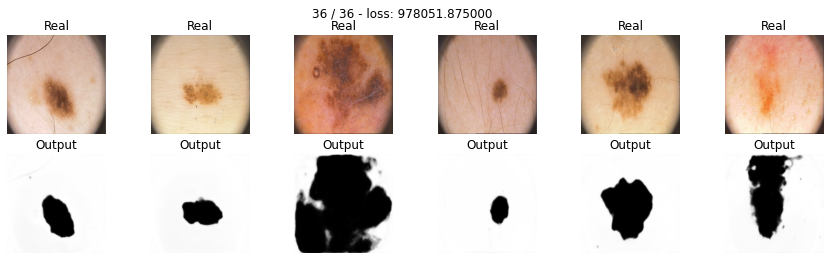

In [6]:
unet_model = UNet(3,1).to(device)

loss_train_plot = []
loss_val_plot  = []

max_epochs =36
optim = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
train(unet_model, optim, bce_loss, max_epochs, data_tr, data_val)

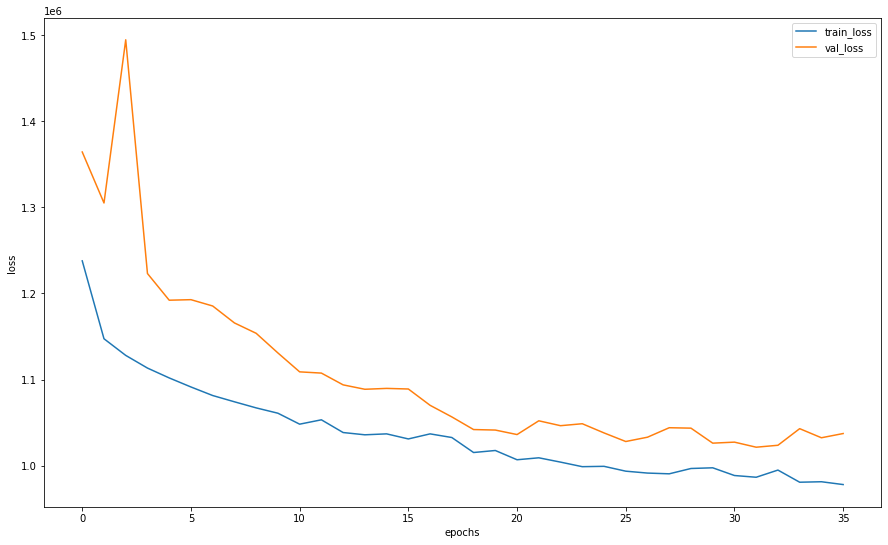

In [7]:
plt.figure(figsize=(15, 9))
plt.plot(loss_train_plot, label="train_loss")
plt.plot(loss_val_plot, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [8]:
score_model(unet_model, GetIOU, data_val, thresh=0.5, NumClasses = 1)

count batches iter
count batches iter


array([0.68600555])

In [9]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

t/1024**3 ,r/1024**3, a/1024**3, f/1024**3

(14.755615234375, 11.76953125, 0.22217845916748047, 11.54735279083252)

In [10]:
torch.cuda.empty_cache()

In [11]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

t/1024**3 ,r/1024**3, a/1024**3, f/1024**3

(14.755615234375, 2.3046875, 0.22217845916748047, 2.0825090408325195)

In [12]:
X_batch, Y_label = next(iter(data_val))
with torch.no_grad():
  unet_model.eval()
  Y_pred = unet_model(X_batch.to(device))

outputs = Y_pred.squeeze(1).byte().cpu().detach().numpy() # BATCH x 1 x H x W => BATCH x H x W
labels = Y_label.squeeze(1).byte().cpu().detach().numpy()

GetIOU(outputs, labels, thresh=0.5, NumClasses=1)

array([0.63489197])

AttributeError: ignored

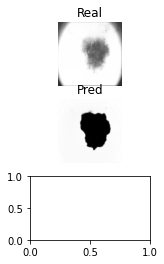

In [13]:
clear_output(wait=True)
for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(X_batch[k][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_pred[k][0].cpu().detach().numpy(), cmap='binary')
    plt.title('Pred')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(labels[k].cpu(), cmap='binary')
    plt.title('Truth')
    plt.axis('off')
plt.show()